# 天池二手车交易价格预测比赛

## 1. 导库

In [1]:
import numpy as np
import pandas as pd
# pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
# import missingno as msno

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)

## 2. 理清分析思路

1) 导入训练集和测试集

2) 预览数据 `.head()` / `.tail()`，并打印两个数据集的 `.shape`

3) 检查两数据集的数值类型，初步判断有无缺失值 `.info()`

4) 数据的描述性统计 `.describe()`， 检查每个统计量（重点：count， mean， std， min， max；std 接近或等于0的可以暂时忽略了, min=0 或 max=9999 等是否合理）

5) 分析预测值的分布，检查离群点。若与正态分布相差太远可考虑进行转换 `np.log1p(y)` / y^0.5 / y^0.33 等等

6) 对每列的数据类型进行必要的转换（如：日期类型，文本类型等）

7) 统计每列缺失值数量、占比，nunique, 最大最小值数量、占比，众数（合并训练集和测试集进行统计）

8) 对每列数据的分布进行可视化（数字特征、分类特征、日期特征分开分析）

9) 数字特征分析
- 相关性分析 `df.corr()`
- 查看几个特征得 偏度和峰值
- 每个数字特征得分布可视化 `sns.distplot()`
- 数字特征相互之间的关系可视化 `sns.pairplot()`, `sns.heatmap()`
- 多变量互相回归关系可视化 `sns.regplot()`

10) 类型特征分析
- unique分布 `.nunique()`
- 类别特征箱形图可视化 `sns.boxplot()`
- 类别特征的小提琴图可视化 `sns.volinplot()`
- 类别特征的柱形图可视化类别 `sns.barplot()`
- 特征的每个类别频数可视化(count_plot) `sns.countplot()`

# 3. EDA

## 1) 载入训练集和测试集；

In [3]:
path = './datalab/231784/'
Train_data = pd.read_csv(path+'used_car_train_20200313.csv', sep=' ')
Test_data = pd.read_csv(path+'used_car_testA_20200313.csv', sep=' ')

# 2) 预览数据

In [4]:
print(Train_data.shape, '\n', Test_data.shape)

(150000, 31) 
 (50000, 30)


In [5]:
Train_data.head(3).append(Train_data.tail(3))

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,0,0,20160404,1850,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,-,4366,0,0,20160309,3600,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,0,0,20160402,6222,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
149997,149997,147587,20101003,60.0,11,1.0,1.0,0.0,90,6.0,0.0,3302,0,0,20160328,7500,44.733481,-3.105721,0.595454,-2.279091,1.423661,0.233353,0.000705,0.118872,0.100118,0.097914,2.439812,-1.630677,2.290197,1.891922,0.414931
149998,149998,45907,20060312,34.0,10,3.0,1.0,0.0,156,15.0,0.0,1877,0,0,20160401,4999,45.658634,-3.204785,-0.441680,-1.179812,0.620680,0.256369,0.000252,0.081479,0.083558,0.081498,2.075380,-2.633719,1.414937,0.431981,-1.659014
149999,149999,177672,19990204,19.0,28,6.0,0.0,1.0,193,12.5,0.0,235,0,0,20160305,4700,45.536383,-3.200326,-1.612893,-0.067144,-1.396166,0.284475,0.000000,0.040072,0.062543,0.025819,1.978453,-3.179913,0.031724,-1.483350,-0.342674


In [6]:
Test_data.head(3).append(Test_data.tail(3))

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,150000,66932,20111212,222.0,4,5.0,1.0,1.0,313,15.0,0.0,1440,0,0,20160329,49.593127,5.246568,1.001130,-4.122264,0.737532,0.264405,0.121800,0.070899,0.106558,0.078867,-7.050969,-0.854626,4.800151,0.620011,-3.664654
1,150001,174960,19990211,19.0,21,0.0,0.0,0.0,75,12.5,1.0,5419,0,0,20160404,42.395926,-3.253950,-1.753754,3.646605,-0.725597,0.261745,0.000000,0.096733,0.013705,0.052383,3.679418,-0.729039,-3.796107,-1.541230,-0.757055
2,150002,5356,20090304,82.0,21,0.0,0.0,0.0,109,7.0,0.0,5045,0,0,20160308,45.841370,4.704178,0.155391,-1.118443,-0.229160,0.260216,0.112081,0.078082,0.062078,0.050540,-4.926690,1.001106,0.826562,0.138226,0.754033
49997,199997,6693,20040412,49.0,1,0.0,1.0,1.0,224,15.0,0.0,3452,0,0,20160305,46.537137,4.170806,0.388595,-0.704689,-1.480710,0.269432,0.105724,0.117652,0.057479,0.015669,-4.639065,0.654713,1.137756,-1.390531,0.254420
49998,199998,96900,20020008,27.0,1,0.0,0.0,1.0,334,15.0,0.0,1998,0,0,20160404,46.771359,-3.296814,0.243566,-1.277411,-0.404881,0.261152,0.000490,0.137366,0.086216,0.051383,1.833504,-2.828687,2.465630,-0.911682,-2.057353
49999,199999,193384,20041109,166.0,6,1.0,NaN,1.0,68,9.0,0.0,3276,0,0,20160322,43.731010,-3.121867,0.027348,-0.808914,2.116551,0.228730,0.000300,0.103534,0.080625,0.124264,2.914571,-1.135270,0.547628,2.094057,-1.552150


In [7]:
# 打印列名
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

| **Field**         | **Description**                                              |
| ----------------- | ------------------------------------------------------------ |
| SaleID            | 交易ID，唯一编码                                             |
| name              | 汽车交易名称，已脱敏                                         |
| regDate           | 汽车注册日期，例如20160101，2016年01月01日                   |
| model             | 车型编码，已脱敏                                             |
| brand             | 汽车品牌，已脱敏                                             |
| bodyType          | 车身类型：豪华轿车：0，微型车：1，厢型车：2，大巴车：3，敞篷车：4，双门汽车：5，商务车：6，搅拌车：7 |
| fuelType          | 燃油类型：汽油：0，柴油：1，液化石油气：2，天然气：3，混合动力：4，其他：5，电动：6 |
| gearbox           | 变速箱：手动：0，自动：1                                     |
| power             | 发动机功率：范围 [ 0, 600 ]                                  |
| kilometer         | 汽车已行驶公里，单位万km                                     |
| notRepairedDamage | 汽车有尚未修复的损坏：是：0，否：1                           |
| regionCode        | 地区编码，已脱敏                                             |
| seller            | 销售方：个体：0，非个体：1                                   |
| offerType         | 报价类型：提供：0，请求：1                                   |
| creatDate         | 汽车上线时间，即开始售卖时间                                 |
| price             | 二手车交易价格（预测目标）                                   |
| v系列特征         | 匿名特征，包含v0-14在内15个匿名特征                          |

## 3) 检查两数据集的数值类型，初步判断有无缺失值

In [8]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null int64
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4       

<font color='red'>
1. 可以看出，除了 notRepairedDamage 列为 object 类型外，其余列都是数值类型。从上面可以看到 notRepairedDamage 列有 ‘-’ 的字符，其余为文本类型数字，应该时导致改列属性编程 object 的原因。

2. model / bodyType / fuelType / gearbox 存在缺失值。
</font>

In [9]:
Test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
SaleID               50000 non-null int64
name                 50000 non-null int64
regDate              50000 non-null int64
model                50000 non-null float64
brand                50000 non-null int64
bodyType             48587 non-null float64
fuelType             47107 non-null float64
gearbox              48090 non-null float64
power                50000 non-null int64
kilometer            50000 non-null float64
notRepairedDamage    50000 non-null object
regionCode           50000 non-null int64
seller               50000 non-null int64
offerType            50000 non-null int64
creatDate            50000 non-null int64
v_0                  50000 non-null float64
v_1                  50000 non-null float64
v_2                  50000 non-null float64
v_3                  50000 non-null float64
v_4                  50000 non-null float64
v_5                  50000 non

情况和 Train_data 一致。

## 4) 数据的描述性统计

In [4]:
Train_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.0,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,2583.077267,0.000007,0.0,2.016033e+07,5923.327333,44.406268,-0.044809,0.080765,0.078833,0.017875,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,1885.363218,0.002582,0.0,1.067328e+02,7501.998477,2.457548,3.641893,2.929618,2.026514,1.193661,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,2.015062e+07,11.000000,30.451976,-4.295589,-4.470671,-7.275037,-4.364565,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,1018.000000,0.000000,0.0,2.016031e+07,1300.000000,43.135799,-3.192349,-0.970671,-1.462580,-0.921191,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,2196.000000,0.000000,0.0,2.016032e+07,3250.000000,44.610266,-3.052671,-0.382947,0.099722,-0.075910,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,3843.000000,0.000000,0.0,2.016033e+07,7700.000000,46.004721,4.000670,0.241335,1.565838,0.868758,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,8120.000000,1.000000,0.0,2.016041e+07,99999.000000,52.304178,7.320308,19.035496,9.854702,6.829352,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


<font color='red'>Tran_data 总体概况如下：</font>
- SaleID 取值从 0 到 149999，纯粹的连续整数序列；
- name 的取值也类似，像是 label encoded；
- regdate 本来应该时8位数字的字符串，现在被当成整数了，后面需要转化成日期格式；
- model / bodyType / fuelType	/ gearbox 都做了类型编码，model 列存在一个缺失值；
- power 最大值比较离群，可能搅拌车或者异常值, 最小值是 0，一般来说车子都是有动力的；
- kilometer 的中位数时15万公里，并且这也是最大值，说明二手车交易的这些车至少一半都是行驶了不低于15万公里的；
- regionCode 也做了 label encodeing；
- seller 只有 0 和 1 两个取值，对模型没什么用；
- offerType 只有 一个 0 取值，对模型没什么用；
- creatDate 本来应该时8位数字的字符串，现在被当成整数了，后面需要转化成日期格式；
- price 均值是 5923，而中位数只有 3250，明显是被平均了，一看最大值竟然有 99999， 这对于回归预测非常不利；
- v 系列的列是做了标准化的。

In [11]:
Test_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,regionCode,seller,offerType,creatDate,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,48587.000000,47107.000000,48090.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,174999.500000,68542.223280,2.003393e+07,46.844520,8.056240,1.782185,0.373405,0.224350,119.883620,12.595580,2590.604820,0.0,0.0,2.016033e+07,44.418233,-0.037238,0.050534,0.084640,0.015001,0.248669,0.045021,0.122744,0.057997,0.062000,-0.017855,-0.013742,-0.013554,-0.003147,0.001516
std,14433.901067,61052.808133,5.368870e+04,49.469548,7.819477,1.760736,0.546442,0.417158,185.097387,3.908979,1876.970263,0.0,0.0,7.951521e+01,2.429950,3.642562,2.856341,2.026510,1.193026,0.044601,0.051766,0.195972,0.029211,0.035653,3.747985,3.231258,2.515962,1.286597,1.027360
min,150000.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.0,0.0,2.015061e+07,28.987024,-4.137733,-4.205728,-5.638184,-4.287718,0.000000,0.000000,0.000000,0.000000,0.000000,-9.160049,-5.411964,-8.916949,-4.123333,-6.112667
25%,162499.750000,11203.500000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,1030.000000,0.0,0.0,2.016031e+07,43.139621,-3.191909,-0.971266,-1.453453,-0.928089,0.243762,0.000044,0.062644,0.035084,0.033714,-3.700121,-1.971325,-1.876703,-1.060428,-0.437920
50%,174999.500000,52248.500000,2.003091e+07,29.000000,6.000000,1.000000,0.000000,0.000000,109.000000,15.000000,2219.000000,0.0,0.0,2.016032e+07,44.611084,-3.050756,-0.388117,0.097881,-0.070225,0.257877,0.000815,0.095828,0.057084,0.058764,1.613212,-0.355843,-0.142779,-0.035956,0.138799
75%,187499.250000,118856.500000,2.007110e+07,65.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,3857.000000,0.0,0.0,2.016033e+07,45.992639,3.997323,0.240548,1.562700,0.863731,0.265328,0.102025,0.125438,0.079077,0.087489,2.832708,1.262914,1.764335,0.941469,0.681163
max,199999.000000,196805.000000,2.015121e+07,246.000000,39.000000,7.000000,6.000000,1.000000,20000.000000,15.000000,8121.000000,0.0,0.0,2.016041e+07,51.751684,7.553517,18.394570,9.381599,5.270150,0.291618,0.153265,1.358813,0.156355,0.214775,12.338872,18.856218,12.950498,5.913273,2.624622


Test_data 基本没什么区别。

In [5]:
# 打印描述性统计中只有两个值特征的计数，以及唯一 object 特征的值计数
for col in ['seller', 'offerType', 'notRepairedDamage']:
    print(Train_data[col].value_counts(), '\n') 

0    149999
1         1
Name: seller, dtype: int64 

0    150000
Name: offerType, dtype: int64 

0.0    111361
-       24324
1.0     14315
Name: notRepairedDamage, dtype: int64 



In [13]:
# 删掉无统计意义的两个特征
for col in ['seller', 'offerType']:
    del Train_data[col]
    del Test_data[col]

In [15]:
# 打印缺失值的数量
Train_data.isna().sum().sort_values(ascending=False)

notRepairedDamage    24324
fuelType              8680
gearbox               5981
bodyType              4506
model                    1
v_14                     0
price                    0
name                     0
regDate                  0
brand                    0
power                    0
kilometer                0
regionCode               0
creatDate                0
v_0                      0
v_13                     0
v_1                      0
v_2                      0
v_3                      0
v_4                      0
v_5                      0
v_6                      0
v_7                      0
v_8                      0
v_9                      0
v_10                     0
v_11                     0
v_12                     0
SaleID                   0
dtype: int64

## 5）统计每列缺失值数量、占比

In [16]:
# 打印缺失值占比
(Train_data.isna().sum() / Train_data.shape[0]).sort_values(ascending=False)

notRepairedDamage    0.162160
fuelType             0.057867
gearbox              0.039873
bodyType             0.030040
model                0.000007
v_14                 0.000000
price                0.000000
name                 0.000000
regDate              0.000000
brand                0.000000
power                0.000000
kilometer            0.000000
regionCode           0.000000
creatDate            0.000000
v_0                  0.000000
v_13                 0.000000
v_1                  0.000000
v_2                  0.000000
v_3                  0.000000
v_4                  0.000000
v_5                  0.000000
v_6                  0.000000
v_7                  0.000000
v_8                  0.000000
v_9                  0.000000
v_10                 0.000000
v_11                 0.000000
v_12                 0.000000
SaleID               0.000000
dtype: float64

In [17]:
# 设置 seaborn 默认主题
sns.set()

## 5) 分析预测值的分布

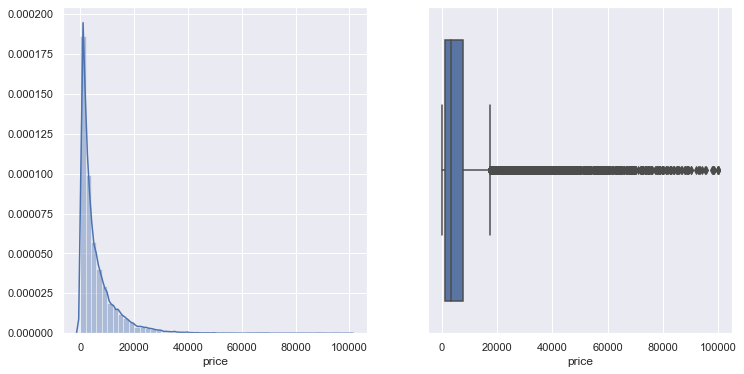

In [18]:
# 预测值分布可视化
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.distplot(Train_data['price'], ax=axes[0])
sns.boxplot(Train_data['price'], ax=axes[1])

<font color='red'>预测值的分布</font>
1. 可以看出 price 的分布是右偏类型，右边带着长尾；通过箱图可以看到大量的离群点。
2. 由于 price 的分布像指数型，故可以控过反向运算 np.log1p() 来获得接近正态分布的预测值。这对于建模非常重要，因为模型的基本假设是数据服从独立同分布IID(independent and identically distributed)。

In [19]:
# 打印预测值的峰度、偏度
print("Skewness: %f" % Train_data['price'].skew())
print("Kurtosis: %f" % Train_data['price'].kurt())

Skewness: 3.346487
Kurtosis: 18.995183


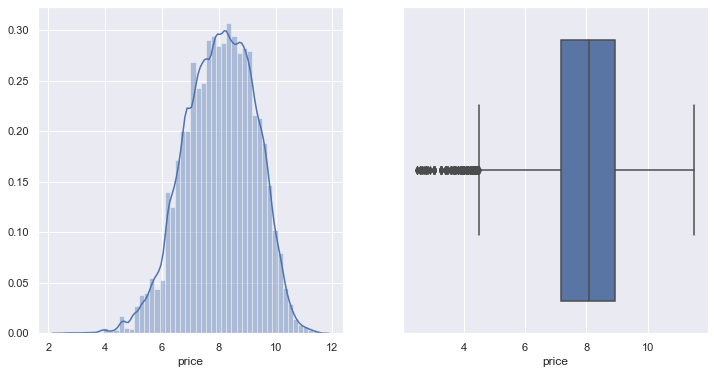

In [20]:
# 预测值分布可视化 (log 变换后)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.distplot(np.log1p(Train_data['price']), ax=axes[0])
sns.boxplot(np.log1p(Train_data['price']), ax=axes[1])

In [21]:
# 打印预测值的峰度、偏度 (log 变换后)
print("Skewness: %f" % np.log1p(Train_data['price']).skew())
print("Kurtosis: %f" % np.log1p(Train_data['price']).kurt())

Skewness: -0.261727
Kurtosis: -0.182127


对 price 做 log 变换后其分布更接近正态分布了。

skew、kurt说明参考 https://www.cnblogs.com/wyy1480/p/10474046.html

In [22]:
Train_data['price'] = np.log1p(Train_data['price'])

## 7) 对每列的数据类型进行必要的转换

In [6]:
date_cols = ['regDate', 'creatDate']

# 定义处理日期的函数
def proc_date(x):
    month = x[4:6]
    if month == '00':  # 月份为 ‘00’ 的替换成 ‘01’
        month ='01'
    return x[:4] + month + x[6:]

for col in date_cols:
    Train_data[col] =  pd.to_datetime(Train_data[col].astype(str).apply(proc_date))
    Test_data[col] =  pd.to_datetime(Test_data[col].astype(str).apply(proc_date))
    
    # 创建日期特征
    Train_data[col + '_year'] = Train_data[col].dt.year
    Train_data[col + '_month'] = Train_data[col].dt.month
    Train_data[col + '_day'] = Train_data[col].dt.day
    Train_data[col + '_dayofweek'] = Train_data[col].dt.dayofweek
    
    Test_data[col + '_year'] = Test_data[col].dt.year
    Test_data[col + '_month'] = Test_data[col].dt.month
    Test_data[col + '_day'] = Test_data[col].dt.day
    Test_data[col + '_dayofweek'] = Test_data[col].dt.dayofweek
    

In [7]:
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14', 'regDate_year', 'regDate_month', 'regDate_day',
       'regDate_dayofweek', 'creatDate_year', 'creatDate_month',
       'creatDate_day', 'creatDate_dayofweek'],
      dtype='object')

In [8]:
Train_data.creatDate_day.dtype

dtype('int64')

In [9]:
# 将特征进行分类
cate_cols = ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode']
num_cols = ['power', 'kilometer'] + ['v_{}'.format(i) for i in range(15)]
date_cols = ['regDate_year', 'regDate_month', 'regDate_day', 'regDate_dayofweek', 'creatDate_year', 'creatDate_month', 'creatDate_day', 'creatDate_dayofweek']
cols = date_cols + cate_cols + num_cols

## 8）数字特征分析

In [26]:
# 相关系数矩阵
corr_matrix = Train_data[num_cols].corr()
corr_matrix

,power,kilometer,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
power,1.000000,-0.019631,0.215028,0.023746,-0.031487,-0.185342,-0.141013,0.119727,0.025648,-0.060397,0.155956,-0.140203,-0.092717,-0.122107,0.161990,-0.103430,-0.023808
kilometer,-0.019631,1.000000,-0.225034,-0.022228,-0.110375,0.402502,-0.214861,0.049502,-0.024664,-0.017835,-0.407686,-0.149422,0.083358,0.066542,-0.370153,-0.285158,-0.120389
v_0,0.215028,-0.225034,1.000000,0.245049,-0.452591,-0.710480,-0.259714,0.726250,0.243783,-0.584363,0.514149,-0.186243,-0.582943,-0.667809,0.415711,-0.136938,-0.039809
v_1,0.023746,-0.022228,0.245049,1.000000,-0.001133,-0.001915,-0.000468,0.109303,0.999415,-0.110806,-0.298966,-0.007698,-0.921904,0.370445,-0.087593,0.017349,0.002143
v_2,-0.031487,-0.110375,-0.452591,-0.001133,1.000000,0.001224,-0.001021,-0.921857,0.023877,0.973689,0.180285,-0.236164,0.274341,0.800915,0.535270,-0.055376,-0.013785
v_3,-0.185342,0.402502,-0.710480,-0.001915,0.001224,1.000000,-0.001694,-0.233412,-0.000747,0.191278,-0.933161,0.079292,0.247385,0.429777,-0.811301,-0.246052,-0.058561
v_4,-0.141013,-0.214861,-0.259714,-0.000468,-0.001021,-0.001694,1.000000,-0.259739,-0.011275,-0.054241,0.051741,0.962928,0.071116,0.110660,-0.134611,0.934580,-0.178518
v_5,0.119727,0.049502,0.726250,0.109303,-0.921857,-0.233412,-0.259739,1.000000,0.091229,-0.939385,0.010686,-0.050343,-0.440588,-0.845954,-0.258521,-0.162689,0.037804
v_6,0.025648,-0.024664,0.243783,0.999415,0.023877,-0.000747,-0.011275,0.091229,1.000000,-0.085410,-0.294956,-0.023057,-0.917056,0.386446,-0.070238,0.000758,-0.003322
v_7,-0.060397,-0.017835,-0.584363,-0.110806,0.973689,0.191278,-0.054241,-0.939385,-0.085410,1.000000,0.028695,-0.264091,0.410014,0.813175,0.385378,-0.154535,-0.020218


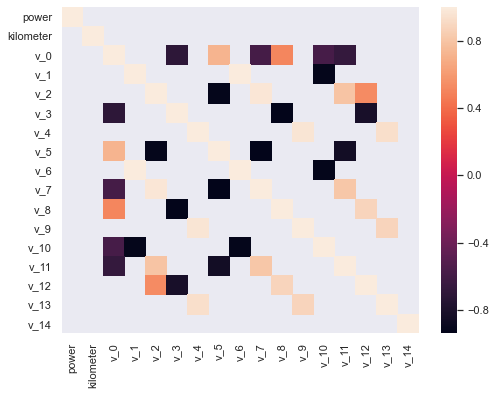

In [27]:
# 相关系数可视化
fig = plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix.mask(lambda x: abs(x)<.5)) # 过滤绝对值小于.5的

从图中可以看出v系列不少呈强正、负相关关系

In [28]:
# 打印数字特征的峰度、偏度
print(Train_data[num_cols].skew(), '\n', Train_data[num_cols].kurt())

power        65.863178
kilometer    -1.525921
v_0          -1.316712
v_1           0.359454
v_2           4.842556
v_3           0.106292
v_4           0.367989
v_5          -4.737094
v_6           0.368073
v_7           5.130233
v_8           0.204613
v_9           0.419501
v_10          0.025220
v_11          3.029146
v_12          0.365358
v_13          0.267915
v_14         -1.186355
dtype: float64 
 power        5733.451054
kilometer       1.141934
v_0             3.993841
v_1            -1.753017
v_2            23.860591
v_3            -0.418006
v_4            -0.197295
v_5            22.934081
v_6            -1.742567
v_7            25.845489
v_8            -0.636225
v_9            -0.321491
v_10           -0.577935
v_11           12.568731
v_12            0.268937
v_13           -0.438274
v_14            2.393526
dtype: float64


In [ ]:
# 数字特征的峰度、偏度可视化
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.distplot(Train_data[num_cols].skew(),color='blue',axlabel ='Skewness', ax=axes[0])
sns.distplot(Train_data[num_cols].kurt(),color='orange',axlabel ='Kurtness', ax=axes[1])

In [ ]:
# 每个数字特征的分布可视化
f = pd.melt(Train_data, value_vars=(num_cols+['price']))
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(sns.distplot, "value")

In [ ]:
# 所有数字特征之间的关系可视化
sns.pairplot(Train_data[num_cols + ['price']]
#              ,diag_kind='kde'
            )

## 9）类型特征分析

In [29]:
# unique 分布
Train_data[cate_cols].nunique()

name                 99662
model                  248
brand                   40
bodyType                 8
fuelType                 7
gearbox                  2
notRepairedDamage        2
regionCode            7905
dtype: int64

In [31]:
# 打印每个类型特征非重复值
for col in cate_cols:
	print(f'unique values of {col}:\n', Train_data[col].unique())

unique values of name:
 [   736   2262  14874 ... 147587  45907 177672]
unique values of model:
 [ 30.  40. 115. 109. 110.  24.  13.  26.  19.   7.   1.  48.  65. 138.
 105. 114.   0.   8.  78.  21.   3.   4.  31. 121.  75.  17. 107.  16.
 111.  47.   5.  44. 200. 155.  87.  20.  22.  63.  49.  29.  88.  60.
  73.  39.  23.  11.  69. 167. 199. 178. 101.   6.  10.  57.  33.  32.
  52.  46.  74.  93. 125.  41. 127. 104.  98.  68. 156. 116. 170. 160.
  85.  80. 143.  77. 166.  53.  66. 203.  14.  42. 119. 174. 177. 210.
  36. 238.  70.  58. 126.  84.  97. 108. 192.  64.  15.  95.  54. 142.
  55. 218. 222. 163.  76.  83. 122.  18. 124. 106.  59. 228. 164. 165.
 145.  94. 186. 220. 179.  67.  71.  25. 144. 212. 172. 168. 206. 152.
 123. 182.  38. 117. 132.  99. 183. 219.  62. 173.  82.  34. 102. 213.
  92. 162.  43. 175.  35.  61. 113. 137. 226. 161. 134. 202. 130. 146.
 139.  45. 112. 227. 195.   2.  51. 232. 129. 135. 169. 191. 148. 140.
   9. 201. 237. 221. 171. 196. 204. 185. 147. 189. 

In [ ]:
plt.figure(figsize=(20, 18))
i = 1
for f in cate_cols + date_cols + num_cols:
    if Train_data[f].nunique() <= 50:
        plt.subplot(5, 3, i)
        i += 1
        v = Train_data.groupby(f)['price'].agg({f + '_price_mean': 'mean'}).reset_index()
        fig = sns.barplot(x=f, y=f + '_price_mean', data=v)
        for item in fig.get_xticklabels():
            item.set_rotation(90)
plt.tight_layout()
plt.show()

简单看几个n unique比较小的特征上面的price的均值的分布。可以发现regDate_year和kilometer的趋势变化很明显，这也对应了上面的相关性分布，这两个特征跟price的相关性都挺高。kilometer应该是被离散化过的，只保留了整数。

In [ ]:
## 类别特征箱形图可视化

# 因为 name和 regionCode的类别太稀疏了，这里我们把不稀疏的几类画一下
categorical_features = ['model',
                         'brand',
                         'bodyType',
                         'fuelType',
                         'gearbox',
                         'notRepairedDamage']

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

# 缺失值填充未 MISSING 类别
f = pd.melt(Train_data.fillna('missing'), id_vars=['price'], value_vars=categorical_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=6)
g = g.map(boxplot, "value", "price")
# g.set_yscale('log')

brand=24 的分布比其他的都更加离散，非常保值。

In [ ]:
## 类别特征的小提琴图可视化
catg_list = categorical_features
target = 'price'
fig = plt.figure(figsize=(16, 18))
for i, catg in enumerate(catg_list):
    fig.add_subplot(3, 2, i+1)
    sns.violinplot(x=catg, y=target, data=Train_data.fillna('missing'))
plt.show()

In [39]:
missing_index = pd.Series(Train_data.index[Train_data['gearbox'] == 'MISSING'])

In [40]:
(missing_index.shift(periods=1) - missing_index).mean()

-25.075585284280937

In [41]:
(Train_data['gearbox'] == 'MISSING').sum()

5981

gearbox 缺失的行 平均相距25行，就近填充也许可行。

In [ ]:
# 类别特征的柱形图可视化
def bar_plot(x, y, **kwargs):
    sns.barplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(Train_data.fillna('missing'), id_vars=['price'], value_vars=categorical_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=6)
g = g.map(bar_plot, "value", "price")

In [ ]:
# 类别特征的每个类别频数可视化(count_plot)
def count_plot(x,  **kwargs):
    sns.countplot(x=x)
    x=plt.xticks(rotation=90)

f = pd.melt(Train_data.fillna('missing'),  value_vars=categorical_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=6)
g = g.map(count_plot, "value")

In [ ]:
# 日期特征可视化
fig = plt.figure(figsize=(16, 6))
for i, col in enumerate(date_cols):
    plt.subplot(2, 4, i+1)
    v = Train_data[col].value_counts()
    fig = sns.barplot(x=v.index, y=v.values)
    for item in fig.get_xticklabels():
        item.set_rotation(90)
    plt.title(col)
plt.tight_layout()
plt.show()

## 10）检查匿名特征在训练集和测试集上的分布

In [ ]:
plt.figure(figsize=(15, 15))
i = 1
for f in num_cols[2:]:
    plt.subplot(5, 3, i)
    i += 1
    sns.distplot(Train_data[f], label='train', color='y', hist=False)
    sns.distplot(Test_data[f], label='test', color='g', hist=False)
plt.tight_layout()
plt.show()

可以看出匿名特征在训练集和测试集上的分布非常吻合

# 4. 特征工程

In [77]:
# 将特征进行分类
cate_cols = ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode']
num_cols = ['power', 'kilometer'] + ['v_{}'.format(i) for i in range(15)]
date_cols = ['regDate_year', 'regDate_month', 'regDate_day', 'regDate_dayofweek', 'creatDate_year', 'creatDate_month', 'creatDate_day', 'creatDate_dayofweek']
cols = date_cols + cate_cols + num_cols

## 1) 异常值处理

In [95]:
def outliers_proc(df, cols, scale=3, plot=True):
    """
    can be used to drop outliers by each column specified by param cols.
    :param df: pandas DataFrame
    :param cols: list-like
    :param scale: scale of box
    """
    
    def get_outlier_idx(serie, box_scale=scale):
        """
        return bool slice index.
        """
        iqr = box_scale * (serie.quantile(0.75) - serie.quantile(0.25))
        lower_bound = serie.quantile(0.25) - iqr
        upper_bound = serie.quantile(0.75) + iqr
        
        return (serie < lower_bound), (serie > upper_bound)
    
    df_n = df.copy()
    for col in cols:
        lower, upper = get_outlier_idx(df_n[col], box_scale=scale)
        
        print(f"Description of data less than the lower bound of {col}:")
        print(df_n.loc[lower, col].describe())
        
        print(f"Description of data larger than the upper bound {col}:")
        print(df_n.loc[upper, col].describe())
        
        if plot:
            fig, axes = plt.subplots(1, 2, figsize=(10, 7))
            sns.boxplot(y=col, data=df_n[lower], palette="Set1", ax=axes[0])
            sns.boxplot(y=col, data=df_n[upper], palette="Set1", ax=axes[1])
        
        print("\n{} values deleted from {}.\n".format((upper | lower).sum(), col))
        df_n.drop(df_n.index[upper | lower], axis=0, inplace=True)
        df_n.reset_index(drop=True)
    
    return df_n

Description of data less than the lower bound of power:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound power:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64

963 values deleted from power.



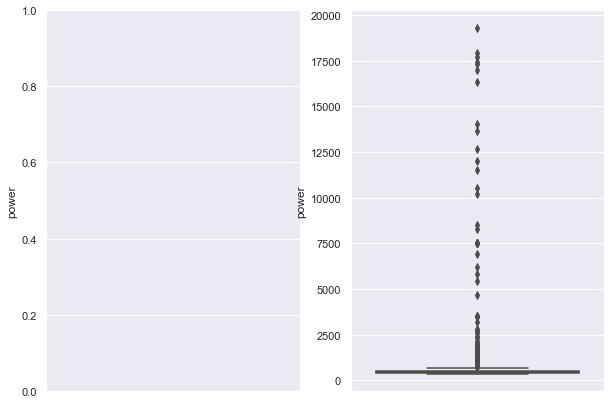

In [96]:
Train_data = outliers_proc(Train_data, ['power'], scale=3, plot=True)

## 2) 特征构造

In [11]:
# 对匿名特征进行降维处理
from sklearn.decomposition import PCA

In [12]:
v_cols = ['v_{}'.format(i) for i in range(15)]

pca = PCA(n_components=.98, whiten=True, random_state=2020)
pca = pca.fit(Train_data[v_cols])

In [13]:
len(pca.explained_variance_ratio_)

5

In [14]:
pca_feats = ['PCA'+str(i+1) for i in range(len(pca.explained_variance_ratio_))]

train_pca_feats = pd.DataFrame(pca.transform(Train_data[v_cols]), columns=pca_feats)
test_pca_feats = pd.DataFrame(pca.fit_transform(Test_data[v_cols]), columns=pca_feats)

In [15]:
train_pca_feats.head()

,PCA1,PCA2,PCA3,PCA4,PCA5
0,-0.747911,0.858216,-0.971811,0.559534,0.651441
1,-1.285109,0.667212,-0.419583,-1.349031,0.115910
2,-1.270957,0.589354,0.612320,-0.636211,-0.137918
3,-1.185746,0.421822,-0.208808,-1.860490,-0.437080
4,-0.497922,0.287183,0.374056,2.082833,1.824120


In [16]:
Train_data = pd.concat([Train_data, train_pca_feats], axis=1)
Test_data = pd.concat([Test_data, test_pca_feats], axis=1)

In [17]:
Train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,regDate_year,regDate_month,regDate_day,regDate_dayofweek,creatDate_year,creatDate_month,creatDate_day,creatDate_dayofweek,PCA1,PCA2,PCA3,PCA4,PCA5
0,0,736,2004-04-02,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,0,0,2016-04-04,1850,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,2004,4,2,4,2016,4,4,0,-0.747911,0.858216,-0.971811,0.559534,0.651441
1,1,2262,2003-03-01,40.0,1,2.0,0.0,0.0,0,15.0,-,4366,0,0,2016-03-09,3600,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,2003,3,1,5,2016,3,9,2,-1.285109,0.667212,-0.419583,-1.349031,0.115910
2,2,14874,2004-04-03,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,0,0,2016-04-02,6222,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,2004,4,3,5,2016,4,2,5,-1.270957,0.589354,0.612320,-0.636211,-0.137918
3,3,71865,1996-09-08,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,0,0,2016-03-12,2400,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,1996,9,8,6,2016,3,12,5,-1.185746,0.421822,-0.208808,-1.860490,-0.437080
4,4,111080,2012-01-03,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,0,0,2016-03-13,5200,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,2012,1,3,1,2016,3,13,6,-0.497922,0.287183,0.374056,2.082833,1.824120


In [18]:
# 训练集和测试集放在一起，方便构造特征
df = pd.concat([Train_data, Test_data], ignore_index=True)

In [19]:
# 使用时间：data['creatDate'] - data['regDate']，反应汽车使用时间，一般来说价格与使用时间成反比
# 不过要注意，数据里有时间出错的格式，所以我们需要 errors='coerce'
df['used_time'] = (pd.to_datetime(df['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(df['regDate'], format='%Y%m%d', errors='coerce')).dt.days

In [20]:
df['used_time'].dtype

dtype('int64')

In [21]:
# 看一下空数据，有 15k 个样本的时间是有问题的，我们可以选择删除，也可以选择放着。
# 但是这里不建议删除，因为删除缺失数据占总样本量过大，7.5%
# 我们可以先放着，因为如果我们 XGBoost 之类的决策树，其本身就能处理缺失值，所以可以不用管；
df['used_time'].isnull().sum()

0

In [22]:
# 从邮编中提取城市信息，相当于加入了先验知识(比赛数据里的邮编是德国的)
df['city'] = df['regionCode'].astype('str').str[:-3]

In [23]:
df['regionCode'].head()

0    1046
1    4366
2    2806
3     434
4    6977
Name: regionCode, dtype: int64

In [24]:
# 空字符替换为 ‘0’
df.loc[df['city'] == '', 'city'] = '0'

In [25]:
df['city'].value_counts()

0    48875
1    42412
2    35272
3    27479
4    20041
5    13529
6     8353
7     3900
8      139
Name: city, dtype: int64

In [26]:
df['city'] = df['city'].astype(np.int8)

In [27]:
df['used_time'].nunique()

9094

In [28]:
from tqdm import tqdm

In [29]:
df['notRepairedDamage'].value_counts()

0.0    148610
-       32355
1.0     19035
Name: notRepairedDamage, dtype: int64

In [90]:
df.select_dtypes(include='O').columns

Index(['notRepairedDamage'], dtype='object')

In [31]:
df['notRepairedDamage'] = df['notRepairedDamage'].astype('str').str.replace('-', '0.0')

df['notRepairedDamage'] = df['notRepairedDamage'].astype(np.float16)

In [32]:
from scipy.stats import entropy

In [33]:
feat_cols = []

### count编码
for feat in tqdm(['regDate', 'creatDate', 'regDate_year','model', 'brand', 'regionCode']):
    df[feat + '_count'] = df[feat].map(df[feat].value_counts())
    feat_cols.append(feat + '_count')

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 90.96it/s]


In [34]:
### 用数值特征对类别特征做统计刻画，随便挑了几个跟price相关性最高的匿名特征
from itertools import product
for f1, f2 in tqdm(product(['model', 'brand', 'regionCode'], ['v_0', 'v_3', 'v_8', 'v_9', 'v_12'])):
    grp = df.groupby(f1, as_index=False)
    feats = grp[f2].agg({f'{f1}_{f2}_max': 'max', 
                         f'{f1}_{f2}_min': 'min',
                         f'{f1}_{f2}_median': 'median', 
                         f'{f1}_{f2}_mean': 'mean',
                         f'{f1}_{f2}_std': 'std', 
                         f'{f1}_{f2}_mad': 'mad'})
    
    df = df.merge(feats, on=f1, how='left')
    feat_cols = list(set(feat_cols) | set(feats))  # 去重

15it [00:33,  2.26s/it]


In [35]:
### 类别特征的二阶交叉
from itertools import combinations
for f1, f2 in tqdm(combinations(['model', 'brand', 'regionCode'], 2)):
    ### 共现次数
    df[f'{f1}_{f2}_count'] = df.groupby([f1, f2])['SaleID'].transform('count')
    ### n unique、熵
    df = df.merge(df.groupby(f1, as_index=False)[f2].agg({f'{f1}_{f2}_nunique': 'nunique',
                                                          f'{f1}_{f2}_ent': lambda x: entropy(x.value_counts() / x.shape[0])
                                                         }), on=f1, how='left')
    
    df = df.merge(df.groupby(f2, as_index=False)[f1].agg({f'{f2}_{f1}_nunique': 'nunique',
                                                          f'{f2}_{f1}_ent': lambda x: entropy(x.value_counts() / x.shape[0])
                                                         }), on=f2, how='left')
    ### 比例偏好
    df[f'{f1}_in_{f2}_prop'] = df[f'{f1}_{f2}_count'] / df[f2 + '_count']
    df[f'{f2}_in_{f1}_prop'] = df[f'{f1}_{f2}_count'] / df[f1 + '_count']
    
    feat_cols.extend([f'{f1}_{f2}_count',
                      f'{f1}_{f2}_nunique', f'{f2}_{f1}_nunique',
                      f'{f1}_{f2}_ent', f'{f2}_{f1}_ent',
                      f'{f1}_in_{f2}_prop', f'{f2}_in_{f1}_prop'])

3it [00:22,  7.36s/it]


<font color='red'> # 类别特征可视化时将数值转化为 Categorical 会导致这一步出错！</font>

In [36]:
from sklearn.model_selection import KFold

train_df = df[~df['price'].isnull()].reset_index(drop=True)
test_df = df[df['price'].isnull()].reset_index(drop=True)

### target encoding目标编码，回归场景相对来说做目标编码的选择更多，不仅可以做均值编码，还可以做标准差编码、中位数编码等
enc_cols = []
stats_default_dict = {'max': train_df['price'].max(),
                      'min': train_df['price'].min(),
                      'median': train_df['price'].median(),
                      'mean': train_df['price'].mean(),
                      'sum': train_df['price'].sum(),
                      'std': train_df['price'].std(),
                      'skew': train_df['price'].skew(),
                      'kurt': train_df['price'].kurt(),
                      'mad': train_df['price'].mad()}

### 暂且选择这三种编码
enc_stats = ['mean', 'std', 'mad']
skf = KFold(n_splits=5, shuffle=True, random_state=2020)

for f in tqdm(['model', 'brand', 'regionCode']):
    enc_dict = {}
    
    for stat in enc_stats:
        enc_dict[f'{f}_target_{stat}'] = stat
        train_df[f'{f}_target_{stat}'] = 0
        test_df[f'{f}_target_{stat}'] = 0
        enc_cols.append(f'{f}_target_{stat}')
        
    for i, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['price'])):
        trn_x, val_x = train_df.iloc[trn_idx].reset_index(drop=True), train_df.iloc[val_idx].reset_index(drop=True)
        enc_df = trn_x.groupby(f, as_index=False)['price'].agg(enc_dict)
        val_x = val_x[[f]].merge(enc_df, on=f, how='left')
        test_x = test_df[[f]].merge(enc_df, on=f, how='left')
        
        for stat in enc_stats:
            val_x[f'{f}_target_{stat}'] = val_x[f'{f}_target_{stat}'].fillna(stats_default_dict[stat])
            test_x[f'{f}_target_{stat}'] = test_x[f'{f}_target_{stat}'].fillna(stats_default_dict[stat])
            train_df.loc[val_idx, f'{f}_target_{stat}'] = val_x[f'{f}_target_{stat}'].values
            test_df[f'{f}_target_{stat}'] += test_x[f'{f}_target_{stat}'].values / skf.n_splits


cols = cate_cols + date_cols + num_cols + feat_cols + enc_cols
sub = test_df[['SaleID']].copy()
test_df = test_df[cols]
labels = train_df['price'].values
train_df = train_df[cols]
print(train_df.shape)
train_df.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.93s/it]


(150000, 162)


,name,model,brand,bodyType,fuelType,gearbox,notRepairedDamage,regionCode,regDate_year,regDate_month,regDate_day,regDate_dayofweek,creatDate_year,creatDate_month,creatDate_day,creatDate_dayofweek,power,kilometer,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,regionCode_v_8_min,model_v_0_mean,regionCode_v_9_max,regionCode_v_3_min,model_v_0_min,model_v_12_mad,regionCode_v_3_median,brand_v_9_mean,regionCode_v_8_max,regionCode_v_8_median,brand_v_3_mean,regionCode_v_3_max,regionCode_v_12_std,brand_v_8_min,brand_v_0_min,model_v_0_median,regionCode_v_8_mean,model_v_9_mean,regionCode_v_12_mad,regionCode_v_8_mad,model_v_0_mad,model_v_12_std,model_v_12_min,regionCode_v_12_mean,regionCode_v_9_mean,brand_v_0_mad,model_v_9_max,regionCode_v_9_mad,brand_v_12_mad,brand_v_9_mad,brand_v_0_median,brand_v_9_std,brand_v_8_max,regionCode_v_0_mean,brand_v_0_mean,brand_v_3_std,brand_v_12_median,regionCode_v_0_max,model_v_9_min,model_v_12_mean,regionCode_v_0_std,model_v_3_mad,brand_count,brand_v_0_std,regionCode_v_12_median,model_v_8_mean,model_v_3_min,model_v_3_std,regionCode_v_3_mad,model_v_0_max,regionCode_v_9_median,brand_v_9_max,brand_v_12_min,regionCode_v_0_median,model_v_9_median,brand_v_8_median,brand_v_3_min,brand_v_12_max,model_v_3_max,model_v_8_std,regionCode_v_3_mean,regionCode,regionCode_v_0_mad,regionCode_v_8_std,brand_v_12_mean,brand_v_8_std,regionCode_v_9_std,model_v_9_mad,brand_v_8_mad,brand_v_3_median,brand,brand_v_12_std,model_count,model_v_8_max,model_v_9_std,model,regionCode_v_12_max,regionCode_v_0_min,regionCode_v_12_min,model_v_3_median,brand_v_3_max,regionCode_v_3_std,brand_v_8_mean,creatDate_count,brand_v_9_min,model_v_8_mad,regionCode_count,brand_v_9_median,model_v_8_median,regionCode_v_9_min,model_v_0_std,model_v_12_max,model_v_8_min,regDate_year_count,model_v_3_mean,brand_v_3_mad,model_v_12_median,brand_v_0_max,regDate_count,model_brand_count,model_brand_nunique,brand_model_nunique,model_brand_ent,brand_model_ent,model_in_brand_prop,brand_in_model_prop,model_regionCode_count,model_regionCode_nunique,regionCode_model_nunique,model_regionCode_ent,regionCode_model_ent,model_in_regionCode_prop,regionCode_in_model_prop,brand_regionCode_count,brand_regionCode_nunique,regionCode_brand_nunique,brand_regionCode_ent,regionCode_brand_ent,brand_in_regionCode_prop,regionCode_in_brand_prop,model_target_mean,model_target_std,model_target_mad,brand_target_mean,brand_target_std,brand_target_mad,regionCode_target_mean,regionCode_target_std,regionCode_target_mad
0,736,30.0,6,1.0,0.0,0.0,0.0,1046,2004,4,2,4,2016,4,4,0,60,12.5,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,0.000000,42.750103,0.103742,-4.480148,28.987024,1.896074,-0.613237,0.075038,0.132026,0.063441,0.733410,6.062231,2.183664,0.0,28.987024,42.918210,0.061578,0.083119,1.773069,0.024186,1.335433,2.292161,-7.781645,0.699833,0.052483,1.548165,0.159750,0.022504,1.953658,0.017391,43.518332,0.022847,0.153849,45.445490,43.331114,2.075349,-1.411952,50.376809,0.000000,-1.352894,2.369732,1.685237,13719,2.282470,0.558707,0.044344,-3.651126,2.000747,1.627380,46.342726,0.049262,0.179249,-8.293423,45.942332,0.083886,0.045827,-5.433129,11.778541,7.375598,0.028413,-0.180360,1046,1.507840,0.029357,-1.041002,0.029004,0.027777,0.010980,0.024024,0.953054,6,2.414547,3145.0,0.132452,0.015693,30.0,6.353017,33.511607,-4.362750,1.361821,9.121568,2.049067,0.048987,7416,0.0,0.023923,47,0.074231,0.041461,0.003489,2.039852,9.825077,0.000000,11899,1.119369,1.700596,-1.560370,49.216535,100,3145.0,1.0,15,0.000000,2.161420,0.229244,1.000000,1.0,1938.0,27,7.390204,3.062849,0.021277,0.000318,3,4553,14,8.091984,2.234541,0.063830,0.000219,2774.671714,3039.693856,2298.168884,3613.811755,4698.830289,3197.888310,8415.931034,10276.594200,6996.870392
1,2262,40.0,1,2.0,0.0,0.0,0.0,4366,2003,3,1,5,2016,3,9,2,0,15.0,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2